In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipBackend
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform, InterpolatedWaveform

from pulser.register.special_layouts import (
    SquareLatticeLayout,
    TriangularLatticeLayout,
)
import matplotlib.pyplot as plt
import qutip

In [26]:
# define trap layout. number of traps needs to be at least double the number of qubits you want

trap_layout = TriangularLatticeLayout(
    n_traps=20,
    spacing=5
)

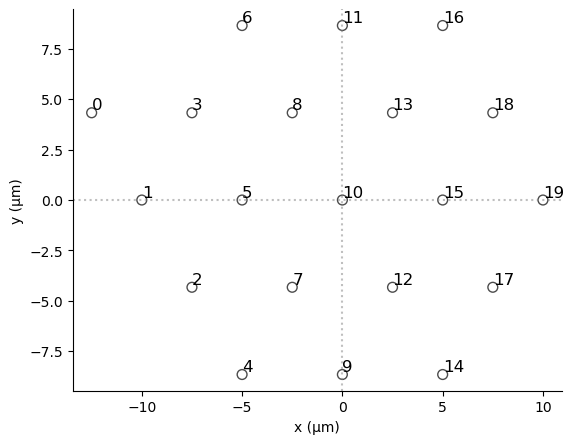

In [9]:
trap_layout.draw()

In [10]:
# from a trap layout you can create a mappable register,
# which is an abstract register where atom positions are not defined
mappable_register = trap_layout.make_mappable_register(n_qubits=3)

In [11]:
sequence = Sequence(mappable_register, MockDevice)

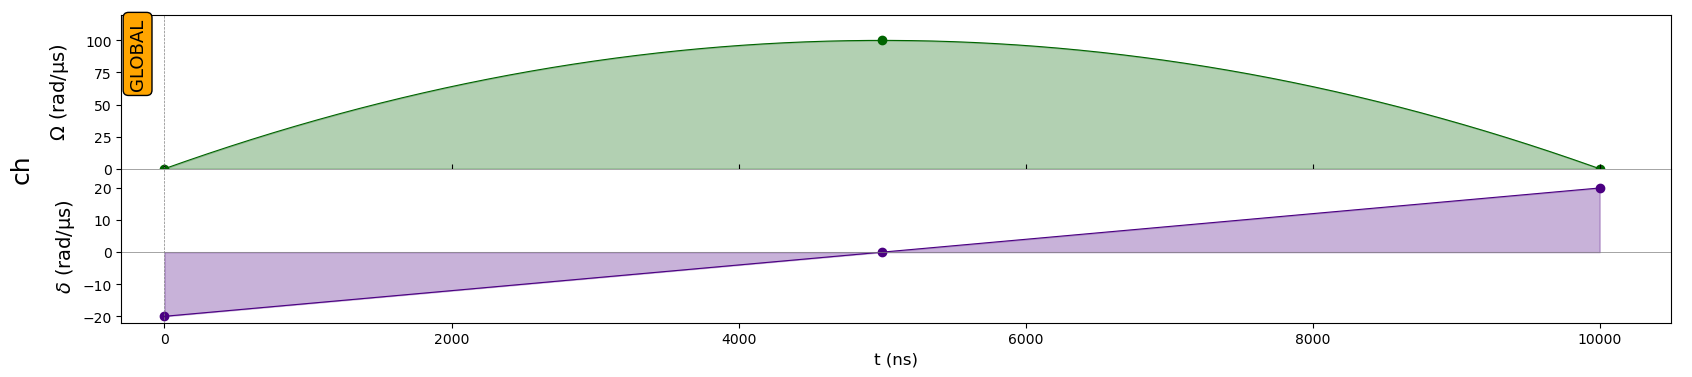

In [14]:
# add pulses

sequence.declare_channel('ch', 'rydberg_global')

omega_wf = InterpolatedWaveform(10000, [0,100,0])
detuning_wf = InterpolatedWaveform(10000, [-20,0,20])
pulse = Pulse(omega_wf, detuning_wf, 0)

sequence.add(pulse, 'ch')

sequence.draw()


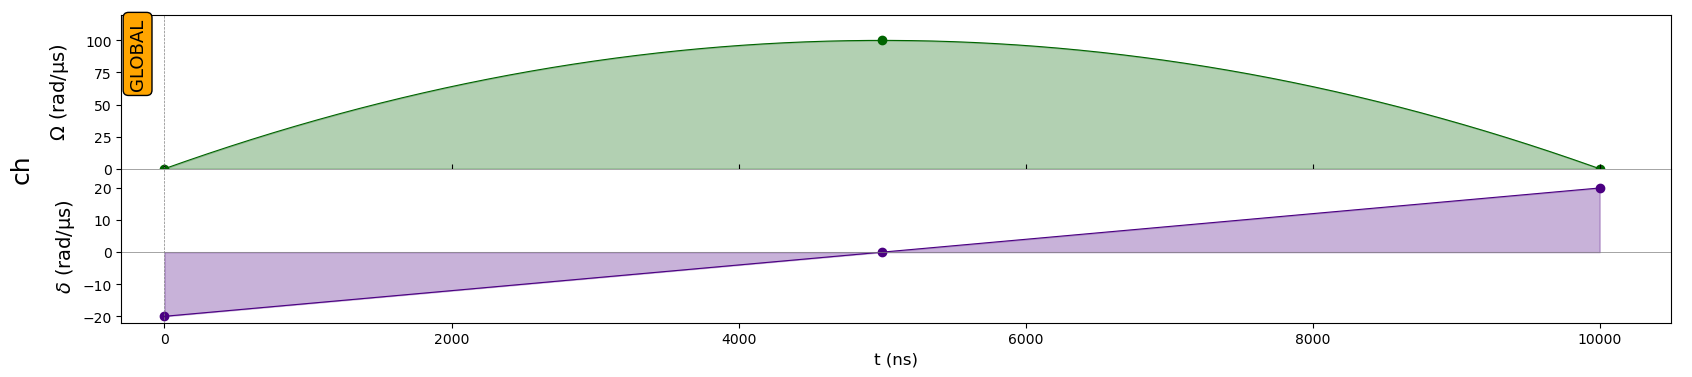

In [ ]:
# add pulses

sequence.declare_channel('ch', 'rydberg_global')

omega_wf = InterpolatedWaveform(10000, [0,100,0])
detuning_wf = InterpolatedWaveform(10000, [-20,0,20])
pulse = Pulse(omega_wf, detuning_wf, 0)

sequence.add(pulse, 'ch')

sequence.draw()


In [20]:
qubit_dictionary = {
    "q0": 5,
    "q1": 10,
    "q2": 15
}

built_sequence = sequence.build(qubits=qubit_dictionary)

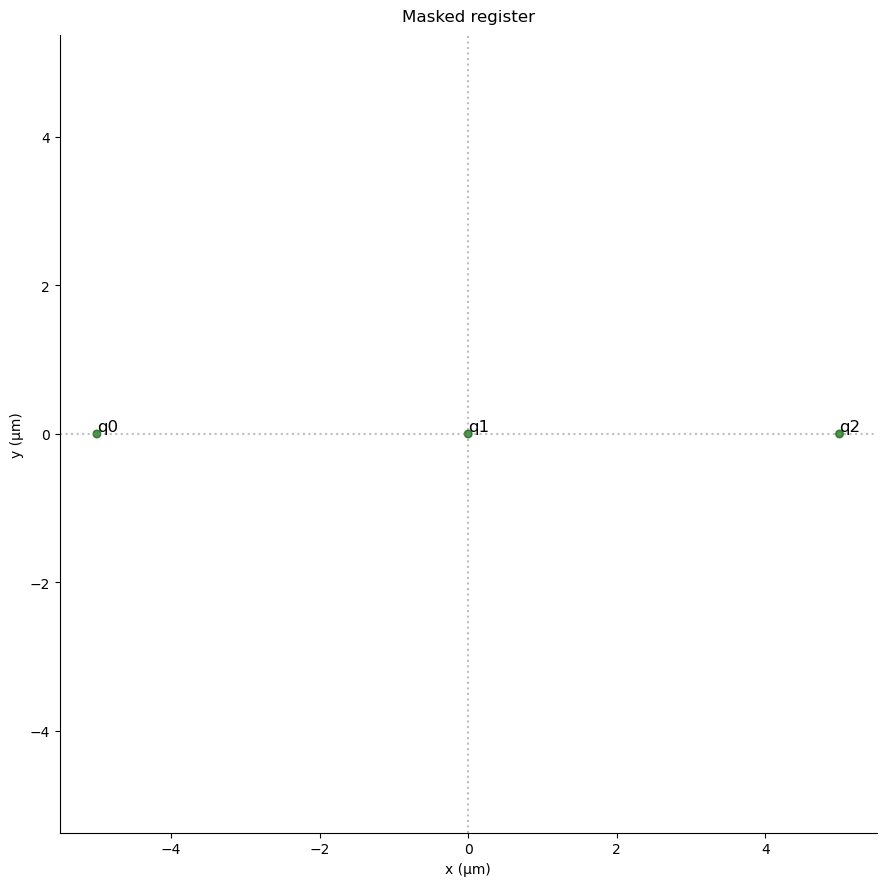

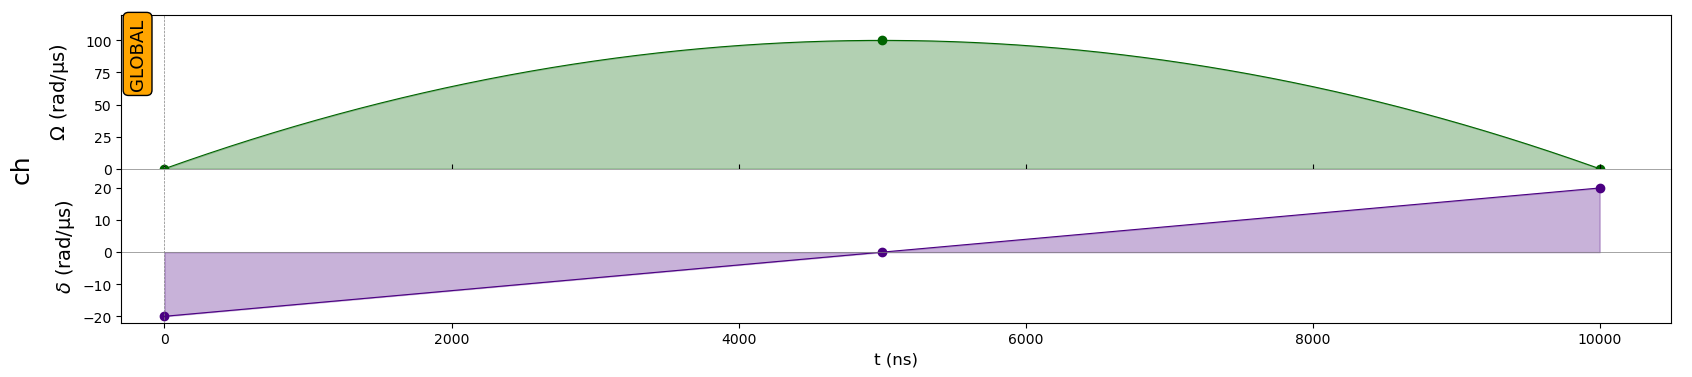

In [22]:
built_sequence.draw(draw_register=True)

In [24]:
# after the sequence is built, everything is the same as in the previous notebooks
simulation = QutipBackend(built_sequence)

results = simulation.run()

final_sampling = results.sample_final_state(1000)

In [25]:
final_sampling

Counter({'001': 16, '010': 3, '100': 24, '101': 957})

## Let's do a naive register optimization
The graph is the one we used last time: V={0,1,2}, E={(0,1), (1,2)}

In [48]:
n_repetitons = 10

scores = []
for i in range(n_repetitons):

    # select three random traps
    trap_labels = np.arange(20)
    traps = np.random.choice(trap_labels, 3, replace=False)

    qubit_dict = {f"q{k}": traps[k] for k in range(3)}

    # build sequence and simulate it
    built_seq = sequence.build(qubits=qubit_dict)
    sim = QutipBackend(built_seq)
    results = sim.run()
    samples = results.sample_final_state(1000)

    # cost function = weighted a verage of number of excitations in final sampling
    # note: we assign negative value to samples that violate the independent set constraint
    cost = 0
    for key in samples:
        if key in ["111", '110', '011']: #these are the non-independent sets
            cost += -10*samples[key]
            continue
        count = key.count('1')
        cost += count*samples[key]
    
    scores.append((traps, cost))



0
1
2
3
4
5
6
7
8
9


In [49]:
scores

[(array([ 7, 16,  1]), -9933),
 (array([13, 10, 19]), -8710),
 (array([ 7,  2, 19]), -5008),
 (array([ 6,  8, 11]), 999),
 (array([ 7, 12,  8]), -8575),
 (array([10,  1,  7]), -9802),
 (array([13,  9, 14]), -3759),
 (array([ 0, 17, 11]), -9964),
 (array([ 3, 17,  2]), -9857),
 (array([15, 17, 14]), 1755)]